# Deep Learning (Dense Neural Network )

## Setup

In [187]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.utils import class_weight

import tensorflow as tf
from tensorflow import keras
from keras import layers

### Data Setup

In [188]:
# Read dataset and create training an validation datasets
training_set = pd.read_csv('../Data/train.csv')
training_set = training_set.drop(columns=["id"])
training_set["defects"] = [1 if value else 0 for value in training_set["defects"].values]


In [189]:
true_data = training_set[training_set["defects"].values == True]
false_data = training_set[training_set["defects"].values == False]

true_feature_data = true_data.drop(columns=["defects"])
false_feature_data = false_data.drop(columns=["defects"])

true_train_proportion = 0.5
false_train_proportion = true_train_proportion # * len(true_feature_data) / len(false_feature_data)

true_X_train, true_X_validation, true_Y_train, true_Y_validation = train_test_split(true_feature_data, true_data["defects"], test_size=(1-true_train_proportion))
false_X_train, false_X_validation, false_Y_train, false_Y_validation = train_test_split(false_feature_data, false_data["defects"], test_size=(1-false_train_proportion))

X_train = pd.concat([true_X_train, false_X_train])
X_validation = pd.concat([true_X_validation, false_X_validation])
Y_train = pd.concat([true_Y_train, false_Y_train])
Y_validation = pd.concat([true_Y_validation, false_Y_validation])

In [190]:
X_train = X_train.to_numpy().tolist()
X_validation = X_validation.to_numpy().tolist()
Y_train = Y_train.to_numpy().tolist()
Y_validation = Y_validation.to_numpy().tolist()

## Model Creation

### Model Architecture

In [280]:
def build_model():

    inputs = keras.Input(shape=(21))
    x = inputs
    
    x = layers.Dense(32, activation=layers.LeakyReLU(0.5))(x)
    x = layers.Dropout(0.2)(x)

    x = layers.Dense(64, activation=layers.LeakyReLU(0.5))(x)
    x = layers.Dropout(0.2)(x)

    x = layers.Dense(32, activation=layers.LeakyReLU(0.5))(x)
    x = layers.Dropout(0.2)(x)

    x = layers.Dense(8, activation=layers.LeakyReLU(0.5))(x)
    x = layers.Dropout(0.2)(x)

    x = layers.Dense(1, activation="sigmoid")(x)

    outputs = x
    model = keras.Model(inputs=inputs, outputs=outputs)

    return model

# Define model's architecture
model = build_model()

# Print model's architecture
model.summary()


Model: "model_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, 21)]              0         
                                                                 
 dense_88 (Dense)            (None, 32)                704       
                                                                 
 dropout_70 (Dropout)        (None, 32)                0         
                                                                 
 dense_89 (Dense)            (None, 64)                2112      
                                                                 
 dropout_71 (Dropout)        (None, 64)                0         
                                                                 
 dense_90 (Dense)            (None, 32)                2080      
                                                                 
 dropout_72 (Dropout)        (None, 32)                0  

### Model Training

In [281]:
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(training_set["defects"]), y=training_set["defects"])
# class_weights = [0.6,2] -- 0.55
class_weights = [0.6,1.8]
class_weight_dict = {}
for i in range(len(class_weights)):
    class_weight_dict[i] = class_weights[i]*(1+i)
    
print("Training class weights:", class_weight_dict)

Training class weights: {0: 0.6, 1: 1.8}


In [282]:
validation_class_weights = np.array([ class_weight_dict[value] for value in Y_validation])
print(len(validation_class_weights))

50882


In [284]:
checkpoint_filepath = './defects.h5'
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(checkpoint_filepath, save_best_only=True)

# Define early stop callback
early_stopping_cb = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)


# Add optimizers and evaluation metrics to model
model.compile(
    optimizer=tf.keras.optimizers.Adam(2e-4, beta_1=0.5),
    # optimizer=keras.optimizers.SGD(learning_rate=0.00125),
    loss=keras.losses.BinaryCrossentropy(),
    # loss=tf.keras.losses.BinaryCrossentropy(),
    weighted_metrics=[
             keras.metrics.BinaryAccuracy(),
             keras.metrics.Precision(name="precision"),
             keras.metrics.Recall(name="recall")
             ],
)

# Train model
history = model.fit(
    X_train,
    Y_train,
    epochs=10,
    class_weight=class_weight_dict,
    validation_data=(X_validation, Y_validation, validation_class_weights),
    # validation_data=(X_validation, Y_validation),
    callbacks=[checkpoint_cb, early_stopping_cb]
    # callbacks=[checkpoint_cb]
) 


Epoch 1/10
1591/1591 [==============================] - 27s 16ms/step - loss: 540.0997 - binary_accuracy: 0.4844 - precision: 0.4647 - recall: 0.6719 - val_loss: 85.6342 - val_binary_accuracy: 0.5006 - val_precision: 0.4811 - val_recall: 0.8599
Epoch 2/10
1591/1591 [==============================] - 10s 7ms/step - loss: 319.8211 - binary_accuracy: 0.5158 - precision: 0.4872 - recall: 0.6657 - val_loss: 129.9312 - val_binary_accuracy: 0.5273 - val_precision: 0.4970 - val_recall: 0.8679
Epoch 3/10
1591/1591 [==============================] - 10s 6ms/step - loss: 262.6940 - binary_accuracy: 0.5372 - precision: 0.5040 - recall: 0.6948 - val_loss: 97.2060 - val_binary_accuracy: 0.5482 - val_precision: 0.5107 - val_recall: 0.8174
Epoch 4/10
1591/1591 [==============================] - 10s 6ms/step - loss: 213.9695 - binary_accuracy: 0.5453 - precision: 0.5106 - recall: 0.6758 - val_loss: 94.0674 - val_binary_accuracy: 0.5293 - val_precision: 0.4980 - val_recall: 0.7799
Epoch 5/10
1591/1591 [

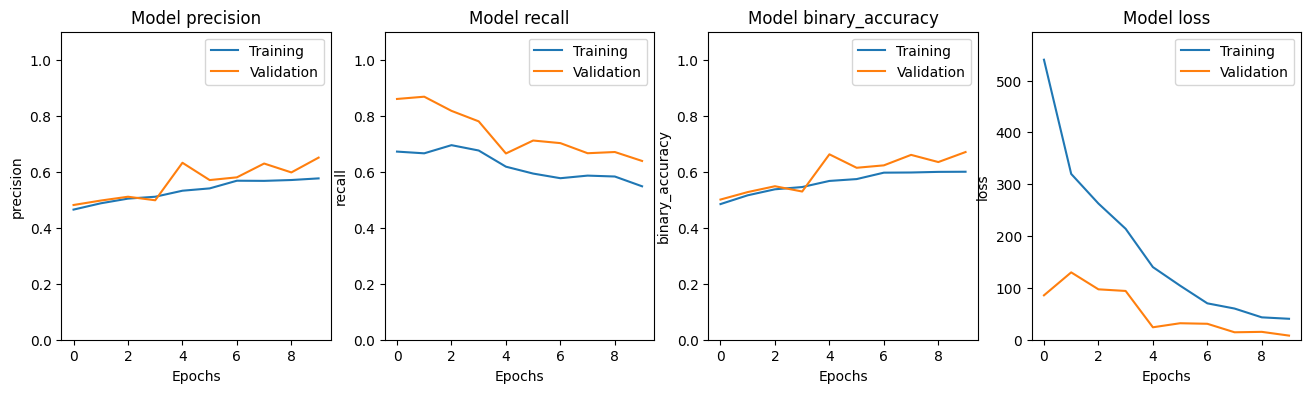

In [285]:
graph_metrics = ["precision", "recall", "binary_accuracy", "loss"]
# graph_metrics = ["binary_accuracy", "loss"]

max_loss = max(history.history["loss"])
max_val_loss = max(history.history["val_loss"])
y_max = [1, 1, 1, max(max_loss, max_val_loss)]

fig, ax = plt.subplots(1, len(graph_metrics), figsize=(16, 4))
ax = ax.ravel()

for i, metric in enumerate(graph_metrics):
    ax[i].plot(history.history[metric])
    ax[i].plot(history.history["val_" + metric])
    ax[i].set_title("Model " + metric)
    ax[i].set_xlabel("Epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["Training", "Validation"])
    ax[i].set_ylim(ymin=0, ymax=1.1*y_max[i])



In [286]:
# Reload best model
best_model = keras.models.load_model(checkpoint_filepath)

In [287]:
validation_predictions = best_model.predict(X_validation)
# validation_predictions = model.predict(X_validation)
validation_prediction_labels = [round(item[0]) for item in validation_predictions.tolist()]


conf_matrix = confusion_matrix(list(Y_validation), validation_prediction_labels, labels=[False, True])

recall_true = conf_matrix[1][1] / (conf_matrix[1][0] + conf_matrix[1][1])
precision_true = conf_matrix[1][1] / (conf_matrix[0][1] + conf_matrix[1][1])
F1_true = 2 * ( (precision_true * recall_true) / (precision_true + recall_true) )

correct_vals = conf_matrix[0][0] + conf_matrix[1][1]
incorrect_vals = conf_matrix[0][1] + conf_matrix[1][0]
accuracy = correct_vals / (correct_vals + incorrect_vals)

print("Correctly predicted labelss: ", correct_vals)
print("Incorrectly predicted labelss: ", incorrect_vals)
print("Model's accuracy: ", accuracy)
print("Model's recall: ", recall_true)
print("Model's precision: ", precision_true)
print("Model's F1 score: ", F1_true)

1591/1591 [==============================] - 1s 856us/step
Correctly predicted labelss:  34839
Incorrectly predicted labelss:  16043
Model's accuracy:  0.6847018592036477
Model's recall:  0.6384842178286507
Model's precision:  0.38275198835577273
Model's F1 score:  0.47859858948942124


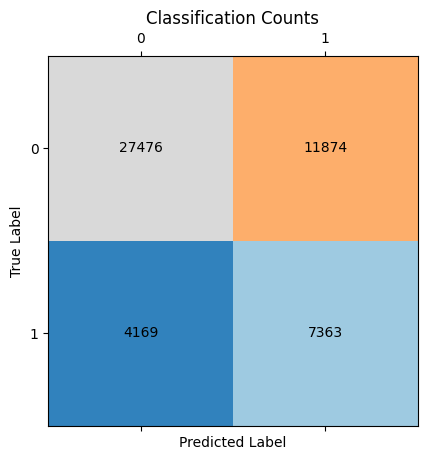

In [288]:
# Plot confusion Matrix
fig, ax = plt.subplots()
ax.matshow(conf_matrix, cmap='tab20c')

# Print classification counts within matrix boxes
for i in range(len(conf_matrix)):
   for j in range(len(conf_matrix[0])):
      c = conf_matrix[j, i]
      ax.text(i, j, str(c), va='center', ha='center')

# Set plot axis titles and show plot
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
ax.set_title('Classification Counts')
plt.show()

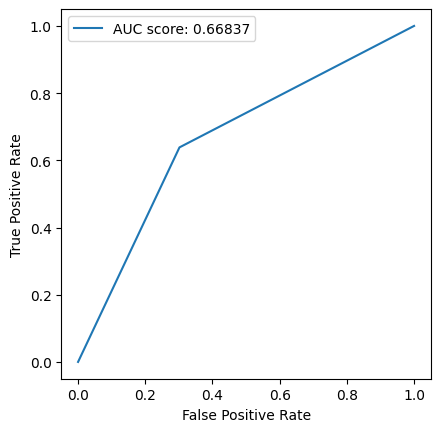

In [289]:

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

# Calculate scores for testing dataset
fpr, tpr, thresholds = roc_curve(list(Y_validation), validation_prediction_labels)

# Calculate AUC score
auc_score = roc_auc_score(list(Y_validation), validation_prediction_labels)

# Print ROC plot
plt.plot(fpr, tpr,)
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(["AUC score: " + str(round(auc_score, 5))], loc="best")
plt.show()